## Objetivo: Encontrar a melhor posição de um jogador dado seu perfil

### Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fifa_df = pd.read_csv('../preprocessing/clean_data_normalized.csv')
fifa_df.head()

,special,age,height_cm,weight_kg,real_face,eur_value,eur_wage,overall,potential,pac,...,nationality_Zambia,nationality_Zimbabwe,work_rate_att_High,work_rate_att_Low,work_rate_att_Medium,work_rate_def_High,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Left,preferred_foot_Right
0,0.959693,0.516129,0.60,0.508197,True,0.776423,1.000000,1.000000,1.000000,0.920000,...,0,0,1,0,0,0,1,0,0,1
1,0.914907,0.451613,0.30,0.377049,True,0.853659,1.000000,0.979167,0.979167,0.906667,...,0,0,0,0,1,0,0,1,1,0
2,0.877799,0.290323,0.40,0.311475,True,1.000000,0.495575,0.958333,1.000000,0.946667,...,0,0,1,0,0,0,0,1,0,1
3,1.000000,0.451613,0.54,0.606557,True,0.788618,0.902655,0.958333,0.958333,0.813333,...,0,0,1,0,0,0,0,1,0,1
4,0.489443,0.483871,0.76,0.704918,True,0.495935,0.407080,0.958333,0.958333,0.933333,...,0,0,0,0,1,0,0,1,0,1


### Retirando colunas irrelevantes

In [2]:
gk_columns = [c for c in fifa_df.columns if 'gk' in c]
fifa_df.drop(gk_columns, axis='columns', inplace=True)

original_positions = 'rs, rw, rf, ram, rcm, rm, rdm, rcb, rb, rwb, st, lw, cf, cam, cm, lm, cdm, cb, lb, lwb, ls, lf, lam, lcm, ldm, lcb, gk'
original_positions = original_positions.replace(' ', '').split(',')

#Filtrando posições que não foram eliminadas pelo filtro de correlação
positions = [p for p in original_positions if p in fifa_df.columns]
positions

['rs', 'rw', 'rcm', 'rdm', 'rcb']

### Obtendo a posição na qual o jogador tem melhor desempenho

In [3]:
# Define a posição do jogador com base na que ele é melhor e cria uma coluna nova p/ armazenar isso
fifa_df['best_pos'] = fifa_df[positions].idxmax(axis='columns')

# Apaga as outras informações sobre a performance do jogador em cada posição
fifa_df.drop(positions, axis='columns', inplace=True)

### Analisando a performance dos modelos de clustering

In [9]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score

# Retirando a variável alvo do conjunto de treinamento
data_X = fifa_df.drop('best_pos', axis='columns')

# Agrupando segundo vários modelos de agrupamento para comparar os resultados
clustering_results = {
    'kmeans' : KMeans(n_clusters=len(positions), max_iter=1000).fit_predict(data_X),
    'agglomerative' : AgglomerativeClustering(n_clusters=len(positions)).fit_predict(data_X)
}

In [11]:
# Calculando o escore de cada modelo
scores = {}
for result in clustering_results:
    scores[result] = silhouette_score(data_X, clustering_results[result])
scores

{'kmeans': 0.0690334755951408, 'agglomerative': 0.035177088750153525}

In [16]:
# Adicionando o grupo predito ao dataset, seguindo o melhor modelo obtido
fifa_df['predicted_label'] = clustering_results[max(scores)]

### Descobrindo a posição predominante em cada cluster

In [17]:
# Agrupa o dataset pelas labels obtidas por clustering e pega a quantidade jogadores em cada posição
clusters_positions = fifa_df.groupby('predicted_label')['best_pos'].value_counts().to_dict()
clusters_positions

{(0, 'rw'): 1529,
 (0, 'rdm'): 1048,
 (0, 'rs'): 815,
 (0, 'rcm'): 543,
 (0, 'rcb'): 256,
 (1, 'rs'): 2021,
 (2, 'rdm'): 2068,
 (2, 'rcm'): 1077,
 (2, 'rcb'): 130,
 (2, 'rw'): 61,
 (2, 'rs'): 2,
 (3, 'rw'): 1929,
 (3, 'rs'): 1270,
 (3, 'rcm'): 464,
 (3, 'rdm'): 108,
 (3, 'rcb'): 8,
 (4, 'rcb'): 3565,
 (4, 'rdm'): 1093,
 (4, 'rcm'): 4,
 (4, 'rw'): 3}

In [18]:
# A label do cluster é a posição mais frequente nele. As 3 células abaixo calculam a posição dos jogadores de cada grupo
position2cluster = {}
curr_max = {k:0 for k in positions}
cp = {}

for k, v in clusters_positions.items():
    cluster, pos = k
    candidates = position2cluster.get(pos, {})
    candidates[cluster] = v
    position2cluster[pos] = candidates
    
len(positions), len(position2cluster.keys())

(5, 5)

In [19]:
df = pd.DataFrame(position2cluster)
max_values = df.idxmax().to_dict()
max_values

{'rcb': 4, 'rcm': 2, 'rdm': 2, 'rs': 1, 'rw': 3}

In [20]:
final_clusters = {p:0 for p in df.columns}

for pos in final_clusters:
    final_clusters[pos] = max_values[pos]
    df.drop(max_values[pos], axis=0, inplace=True)
    df.drop(pos, axis='columns', inplace=True)
    if len(df)>0:
        max_values = df.idxmax().to_dict()
    print(len(df))

# Associação entre o número do grupo e a posição do jogador
final_clusters

4
3
2
1
0


{'rcb': 4, 'rcm': 2, 'rdm': 0, 'rs': 1, 'rw': 3}

### 'Traduzindo' os grupos para posições

In [32]:
cluster2name = inv_map = {v: k for k, v in final_clusters.items()}
fifa_df.predicted_label.replace(cluster2name, inplace=True)
(fifa_df.predicted_label == fifa_df.best_pos).describe()

count     17994
unique        2
top        True
freq       9640
dtype: object

Text(0.5,1,'Original')

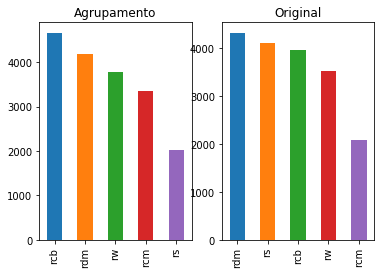

In [45]:
plt.tight_layout()
plt.subplot(1, 2, 1)
fifa_df.predicted_label.value_counts().plot(kind='bar')
plt.title('Agrupamento')

plt.subplot(1, 2, 2)
fifa_df.best_pos.value_counts().plot(kind='bar')
plt.title('Original')

### Visualização gráfica da distribuição dos grupos

In [46]:
# Reduzir as features em 2 para ver a distribuição de grupos
from sklearn.decomposition import PCA
pca = PCA(2)
data_pca = fifa_df.drop(['best_pos', 'predicted_label'], axis='columns')
data_pca = pca.fit_transform(data_pca)

data_pca = pd.DataFrame(data_pca, columns=['x','y'])
data_pca['label'] = fifa_df.predicted_label
data_pca.head()

,x,y,label
0,2.638462,-1.056928,rdm
1,2.021732,-1.034418,rw
2,2.263048,-1.086161,rdm
3,1.982307,-0.541210,rdm
4,-1.073427,-0.337234,rs


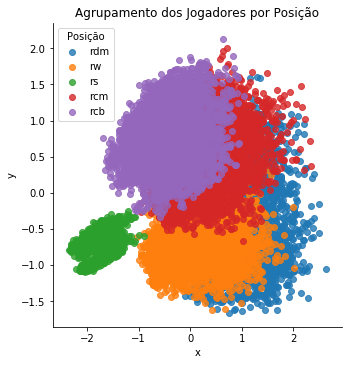

In [47]:
import seaborn as sns
#plot data with seaborn
group_plot = sns.lmplot(data=data_pca, x='x', y='y', hue='label', fit_reg=False, legend=False, legend_out=True)
plt.title("Agrupamento dos Jogadores por Posição")
plt.legend().set_title("Posição")

In [48]:
# Reduzir as features em 3 para ver a distribuição de grupos
from sklearn.decomposition import PCA
pca = PCA(3)
data_pca = fifa_df.drop(['best_pos', 'predicted_label'], axis='columns')
data_pca = pca.fit_transform(data_pca)

data_pca = pd.DataFrame(data_pca, columns=['x','y', 'z'])
data_pca['label'] = fifa_df.predicted_label
data_pca.head()

,x,y,z,label
0,2.638462,-1.056925,-0.157853,rdm
1,2.021732,-1.034416,0.585446,rw
2,2.263047,-1.086156,0.245923,rdm
3,1.982307,-0.541207,-1.193803,rdm
4,-1.073427,-0.337230,-0.650451,rs


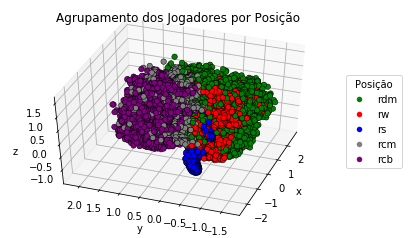

In [50]:
from mpl_toolkits import mplot3d
colors = {
    'rw': 'red',
    'rdm': 'green',
    'rs': 'blue',
    'rcm': 'gray',
    'rcb': 'purple'
}
data_pca['color'] = pd.Series(colors[label] for label in data_pca.label)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(data_pca['x'], data_pca['y'], data_pca['z'], c=data_pca['color'], alpha=1, linewidth=0.5, s=30, edgecolors='none')

df = data_pca.drop_duplicates('label')
for index, row in df.iterrows():
    ax.scatter(row['x'], row['y'], row['z'], c=row['color'] , label=row['label'], alpha=1,linewidth=0.5, s=30, edgecolors='none')

#plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Agrupamento dos Jogadores por Posição')
plt.legend(bbox_to_anchor=(1., .7), loc=2, borderaxespad=0.).set_title('Posição')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45, 200)

Text(0.5,1,'Matriz de Confusão - Posição Predita vs Posição Real')

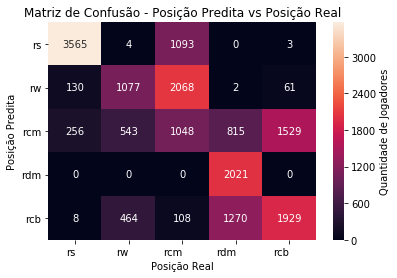

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(fifa_df.predicted_label, fifa_df.best_pos)
cm = pd.DataFrame(cm, columns=positions, index=positions)

heatmap = sns.heatmap(cm, annot=True, fmt='d',cbar_kws={'label': 'Quantidade de Jogadores'})
heatmap.yaxis.set_ticklabels(positions, rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(positions, rotation=0, ha='right', fontsize=10)

plt.ylabel('Posição Predita')
plt.xlabel('Posição Real')
plt.title("Matriz de Confusão - Posição Predita vs Posição Real")